<a href="https://colab.research.google.com/github/78furu/deeplea_adv/blob/master/deeplea_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/github_repos/deeplea_adv/'
%pwd
! git pull

import unet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/github_repos/deeplea_adv
Already up to date.


In [2]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from preproc import training_and_eval, load_and_preprocess_data
from models import Score
import yaml
from collections import namedtuple

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.1+cu101
Using GPU device: Tesla K80


In [3]:
config = yaml.load(open(r'scorenet.yml'))
config2 = {}
for k,d in config.items():
    MyTuple = namedtuple("MyTuple", d)
    if d.get("image_size"):
        d["image_size"] = 28
        d["channels"] = 1
    my_tuple = MyTuple(**d)
    config2[k] = my_tuple

MyTuple = namedtuple("MyTuple", config2)
my_tuple = MyTuple(**config2)

In [4]:
net = Score(my_tuple)
MODEL = net.to(torch.cuda.current_device())
MODEL.input_size=(my_tuple.data.channels,my_tuple.data.image_size,my_tuple.data.image_size)

Dataset: mnist 
 Image shape: (1, 28, 28) 
 Number of train images: 60000 
 Number of test images: 10000 
 Number of classes: 10 



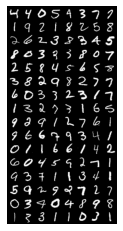

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             544
         GroupNorm-2           [-1, 32, 14, 14]              64
               ELU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          32,832
         GroupNorm-5             [-1, 64, 7, 7]             128
               ELU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 3, 3]         204,928
         GroupNorm-8            [-1, 128, 3, 3]             256
               ELU-9            [-1, 128, 3, 3]               0
  ConvTranspose2d-10             [-1, 64, 7, 7]         204,864
        GroupNorm-11             [-1, 64, 7, 7]             128
              ELU-12             [-1, 64, 7, 7]               0
  ConvTranspose2d-13           [-1, 32, 14, 14]          32,800
        GroupNorm-14     

In [75]:

DATASET_NAME = 'mnist'

# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-3)  
BATCH_SIZE = 128  
NUM_EPOCHS = 30 

trained_model, loss_and_accuracy_history = training_and_eval(DATASET_NAME, 
                                                             MODEL,
                                                             OPTIMIZER,
                                                             BATCH_SIZE, 
                                                             NUM_EPOCHS,
                                                             augment = False, 
                                                             need_summary = True)

Dataset: mnist 
 Image shape: (1, 28, 28) 
 Number of train images: 60000 
 Number of test images: 10000 
 Number of classes: 10 



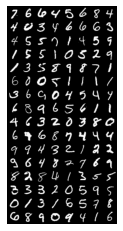

In [6]:
train, test = load_and_preprocess_data("mnist", BATCH_SIZE)

In [76]:
outp = MODEL((train.dataset.data[:32].view(32, 1, 28, 28)/255).to("cuda"))

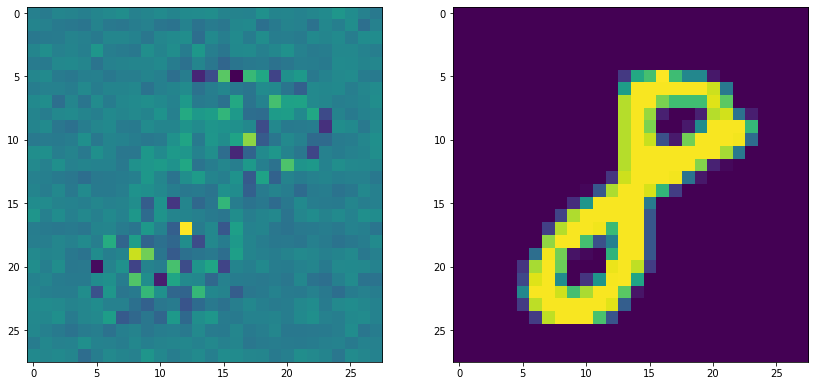

In [77]:
c = 31
image = outp[c].detach().cpu().numpy().astype(float)

fig, axes = plt.subplots(1,2, figsize=(14, 8))

ax = axes[0]
#ax.imshow(np.moveaxis(image, [0,1,2], [2,0,1]))
ax.imshow(image[0])
ax = axes[1]
ax.imshow(train.dataset.data[c])

In [67]:
length = 10
ratio = pow(0.01/10, 1/9)
start = 10
progression = np.array([start * ratio**i for i in range(length)])
num_of_images = 10
epses = np.logspace(-5, -1, 9)

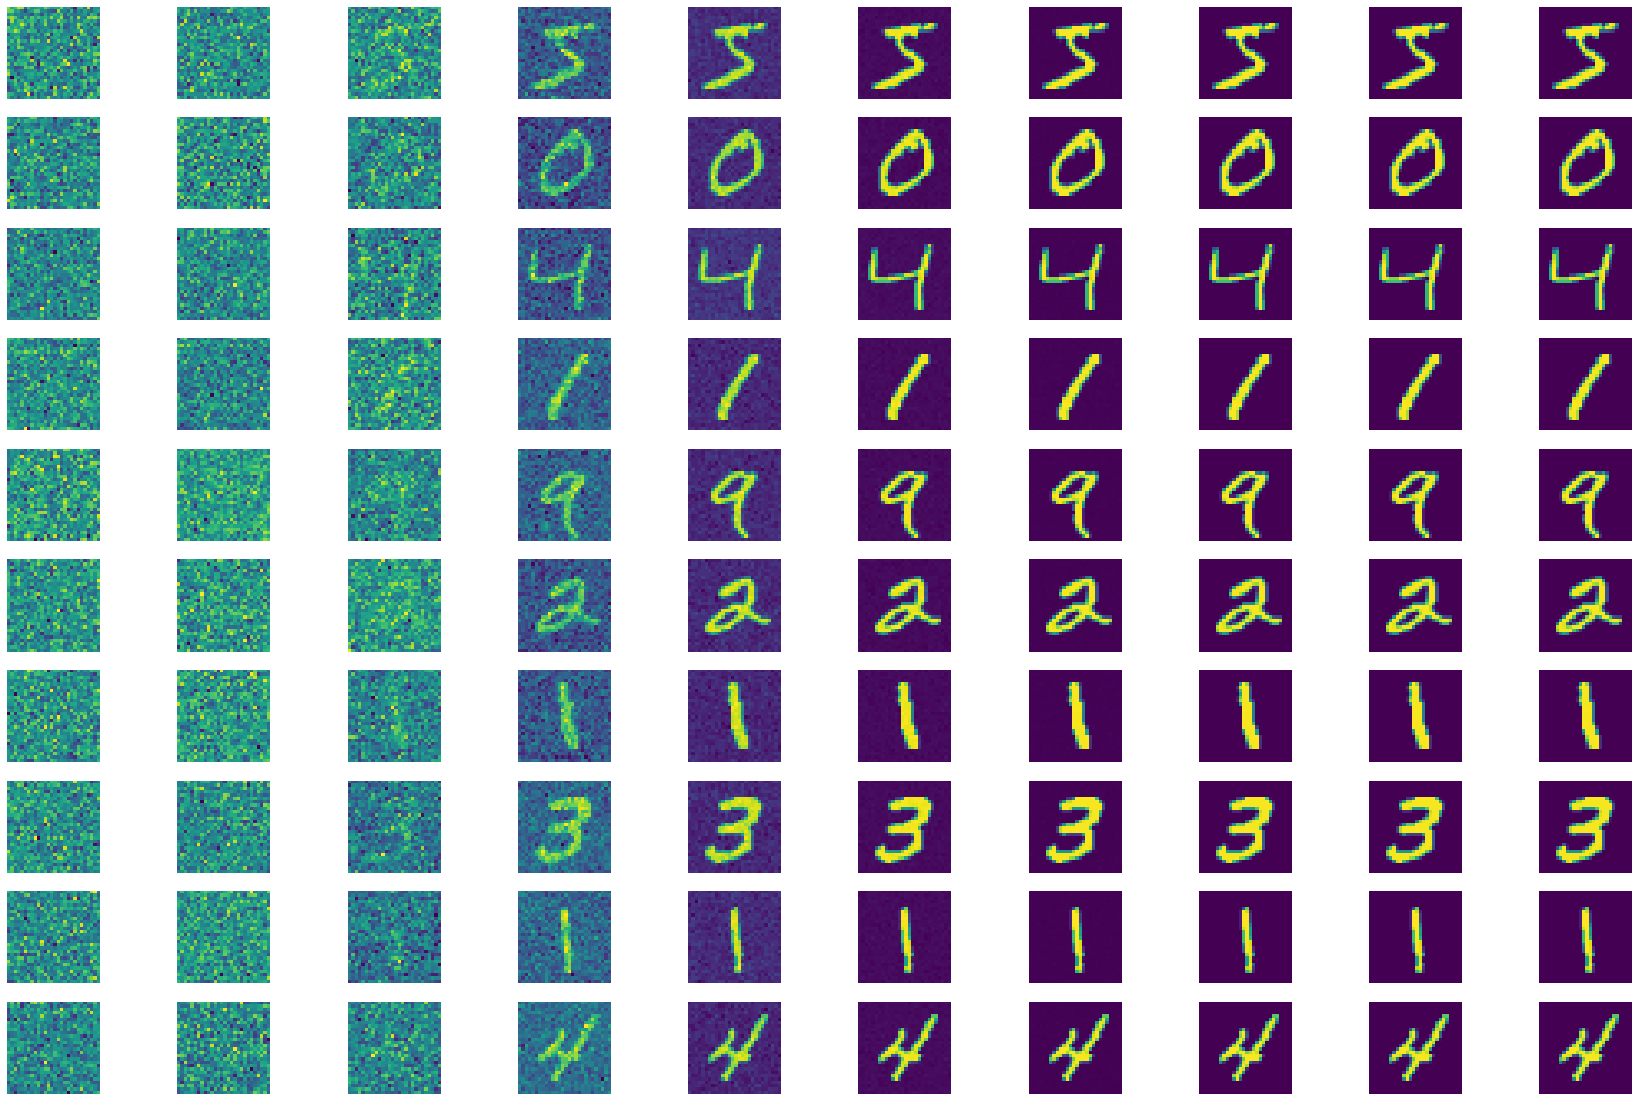

In [12]:


fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow(im_);
        ax.axis('off')

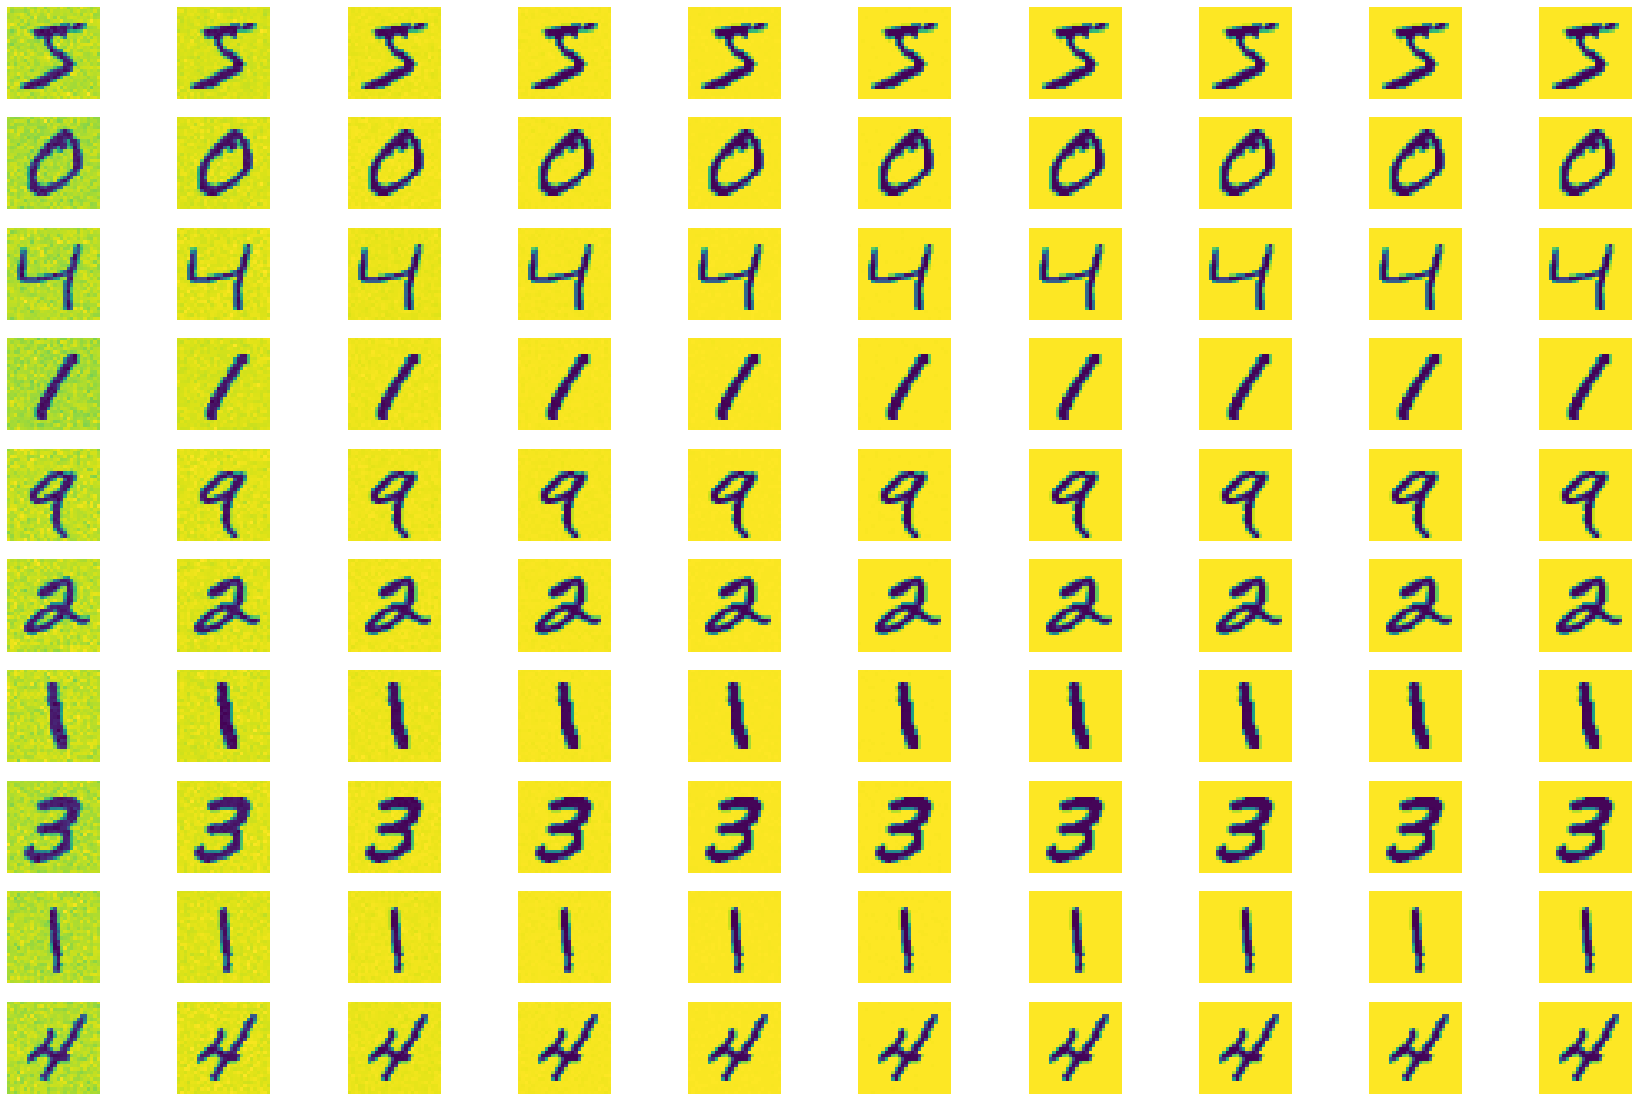

In [14]:
fig, axes = plt.subplots(num_of_images,progression.shape[0], figsize=(30, 20))
for im,c in zip(train.dataset.data, range(num_of_images)):
    for eps, ax in zip(progression, axes[c, :]):
        eps_ = (eps**2/progression[-1]**2)*2e-5
        im_ = im/255 + np.random.normal(scale=eps,size=im.shape)
        #im_ = (im_-np.min(im_))/(np.max(im_)-np.min(im_))
        ax.imshow((im_-im)/eps);
        ax.axis('off')

In [ ]:
device = torch.cuda.current_device()
for sigma in epses:

    for i, (images, labels) in enumerate(train):
        images_o = images.to(device)
        #eps_ = (eps**2/progression[-1]**2)*2e-5
        images = images_o + torch.normal(0, std=sigma, size=images.shape).to(device)
        labels = (images-images_o)/sigma

KeyboardInterrupt: ignored

In [ ]:
torch.normal( std = sigma, size=images.shape)

TypeError: ignored

In [10]:
def annealed_langevin(model, sigmas, eps, T):
    x_0 = torch.rand(1,1, 28, 28).to("cuda")
    for sigma in sigmas:
        alpha = eps*sigma**2/sigmas[-1]**2
        for t in range(T):
            z = torch.normal(0, 1, size = x_0.shape).to("cuda")
            x_0 += alpha/2 * model(x_0) +  np.sqrt(alpha)*z
    return x_0

In [115]:
epsilons = np.logspace(-7.8, -9, 12)
t_s = [1, 10, 50, 100, 200, 500, 1000, 2000,]
#gen_images = [annealed_langevin(MODEL,progression,e, 1000)[0][0].cpu().detach().numpy() for e in epsilons]
gen_images = [annealed_langevin(MODEL,progression,epsilons[-1], t)[0][0].cpu().detach().numpy() for t in t_s]

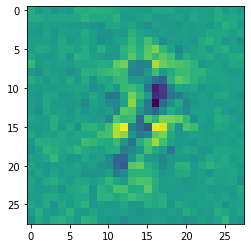

In [78]:
c = annealed_langevin(MODEL,progression,2e-5, 100)
plt.imshow(c[0][0].cpu().detach().numpy())

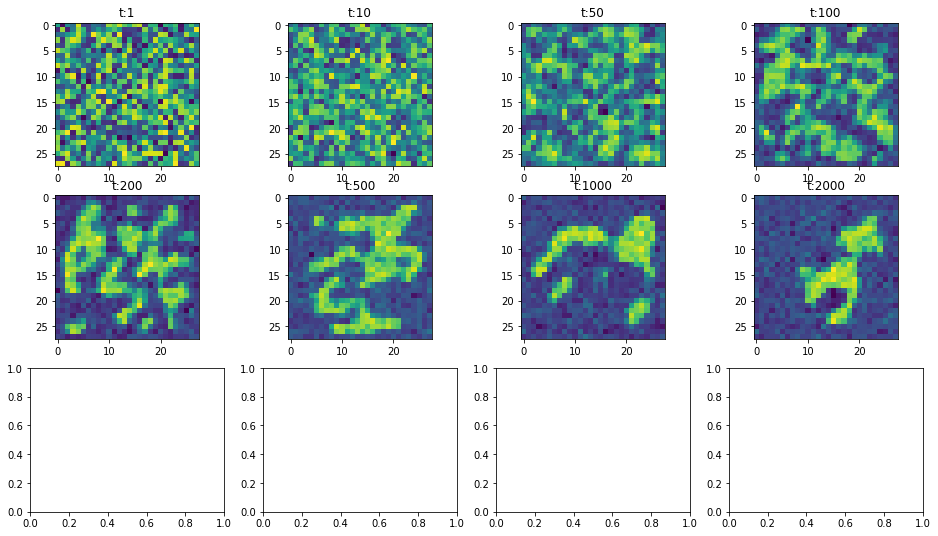

In [116]:
fig, axes = plt.subplots(3,4, figsize = (16,9))

for im, ax, t in zip(gen_images, axes.ravel(), t_s):
    ax.imshow(im)
    ax.set_title(f"t:{t}")

#fig.savefig('figs/different_epses_appr_80_epochs_T_1000.png', dpi = 100)

In [ ]:
!git push

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 1.59 KiB | 816.00 KiB/s, done.
Total 6 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/78furu/deeplea_adv.git
   7933b53..f89d4e8  master -> master


In [27]:
epses

array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01])

In [10]:
progression

array([10.        ,  4.64158883,  2.15443469,  1.        ,  0.46415888,
        0.21544347,  0.1       ,  0.04641589,  0.02154435,  0.01      ])

In [89]:
    torch.cuda.empty_cache()

In [92]:
del gen_images

In [97]:
!pwd

/content/drive/My Drive/github_repos/deeplea_adv


In [103]:
torch.save(MODEL.state_dict(), "model_params.pt")

In [ ]:
loaded_model = Score(*args, **kwargs)
loaded_model.load_state_dict(torch.load("model_params.pt"))

Or save total model:

In [104]:
torch.save(MODEL, 'model.pt')

PicklingError: ignored

In [ ]:
loaded_model = torch.load("model.pt")